# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
        * [1.2.3. Line ratio constraints](#chapter1_2_3)
    * [1.3. Setting up the plotting parameters](#chapter1_3)
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)

<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
# book-keeping variables (optional; for this box only)
volume = '' # base directory
gal = 'nirspec-etc' # prefix label for output files

# Input files
infile = volume+'nirspec_etc_cube_both.fits' # path + name of your input cube
qsotemplate = volume+'nirspec_ETC_QSO.npy' 
#stellartemplates = volume+gal+'hosttemplate.npy'

# Output directories/files
outdir = volume+'' # path + name of directory for saving the output files
path_to_npy_file = volume+'' # path for initproc.npy
logfile = outdir+gal+'_fitlog.txt'

Some general information about your cube:

In [3]:
ncols = 30 # number of columns
nrows = 29 # number of rows
fitrange = [0.98,1.80] #in um

if not os.path.isfile(infile): 
    print('Data cube not found.')

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [4]:
lines = ['Halpha', 'Hbeta', '[OIII]4959', '[OIII]5007']

How many components do you want to be fitted to the emission lines?

In [5]:
maxncomp = 1

In [6]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = 'Halpha'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    ncomp[i][8,13] = 0
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),1.489)
    siginit_gas[i] = np.full(maxncomp,50.)

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [7]:
# Global limit
siglim_gas = np.array([5., 500.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

Description of continuum fitting parameters:
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`. 0 < hostord < 4
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`. 0 < hostord < 4

In [16]:
fcncontfit = 'fitqsohost'
argscontfit = dict()
#argscontfit['blrpar'] = [0., 1.6400, 0.5000/299792.*1.6400,
#                         0., 1.2150, 0.5000/299792.*1.2150]
argscontfit['qsoxdr'] = qsotemplate
argscontfit['qsoord'] = 10
argscontfit['hostord'] = 10
#argscontfit['refit'] = 'ppxf'

#### 1.2.3. Line ratio constraints <a class="anchor" id="chapter1_2_3"></a>
`line1`, `line2`, and `comp` are required. `value` is the initial value of `line1`/`line2`, and `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) The ratio can also be `fixed`.

In [10]:
# Required columns:
#line1 = ['[NI]5198']
#line2 = ['[NI]5200']
#comp = np.array([0], dtype=np.int32)

# Optional columns:
#value = [1.5]
#fixed = [True]
# lower = []
# upper = []

# Write table
#from astropy.table import QTable
#lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [9]:
argspltlin1 = {'nx': 3,
               'ny': 1,
               'line': ['Hbeta', '[OIII]5007', 'Halpha'],
               'size': [0.05, 0.05, 0.05]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [17]:
initproc = { \
        # Required pars
        'fitran': fitrange,
        'fluxunits': 1,
        'infile': infile,
        'label': gal,
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'name': 'PG1411+442',
        'ncomp': ncomp,
        'outdir': outdir,
        'zinit_gas': zinit_gas,
        'zsys_gas': 1.489,
        # Optional pars
        'argscheckcomp': {'sigcut': 3},
        'fcncontfit': fcncontfit,
        'argscontfit': argscontfit,
        'argscontplot': {'xstyle': 'lin',
                         'ystyle': 'lin',
                         'fluxunit_in': 'flambda',
                         'fluxunit_out': 'flambda',
                         'mode': 'dark'},
        'argsreadcube': {'wmapext': None, 'error': True},
        'argspltlin1': argspltlin1,
        #'decompose_qso_fit': 1,
        #'remove_scattered': 1,
        'fcncheckcomp': 'checkcomp',
        'maskwidths_def': 500.,
        'emlsigcut': 2,
        'logfile': logfile,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        'cutrange': np.array([1.4133,1.4743]),
        'nocvdf': 1,
    }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [18]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [12]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [13]:
cols = [15]
rows = [20]

In [19]:
q3df(initproc,cols=cols,rows=rows)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Inline plotting:

<IPython.core.display.Javascript object>


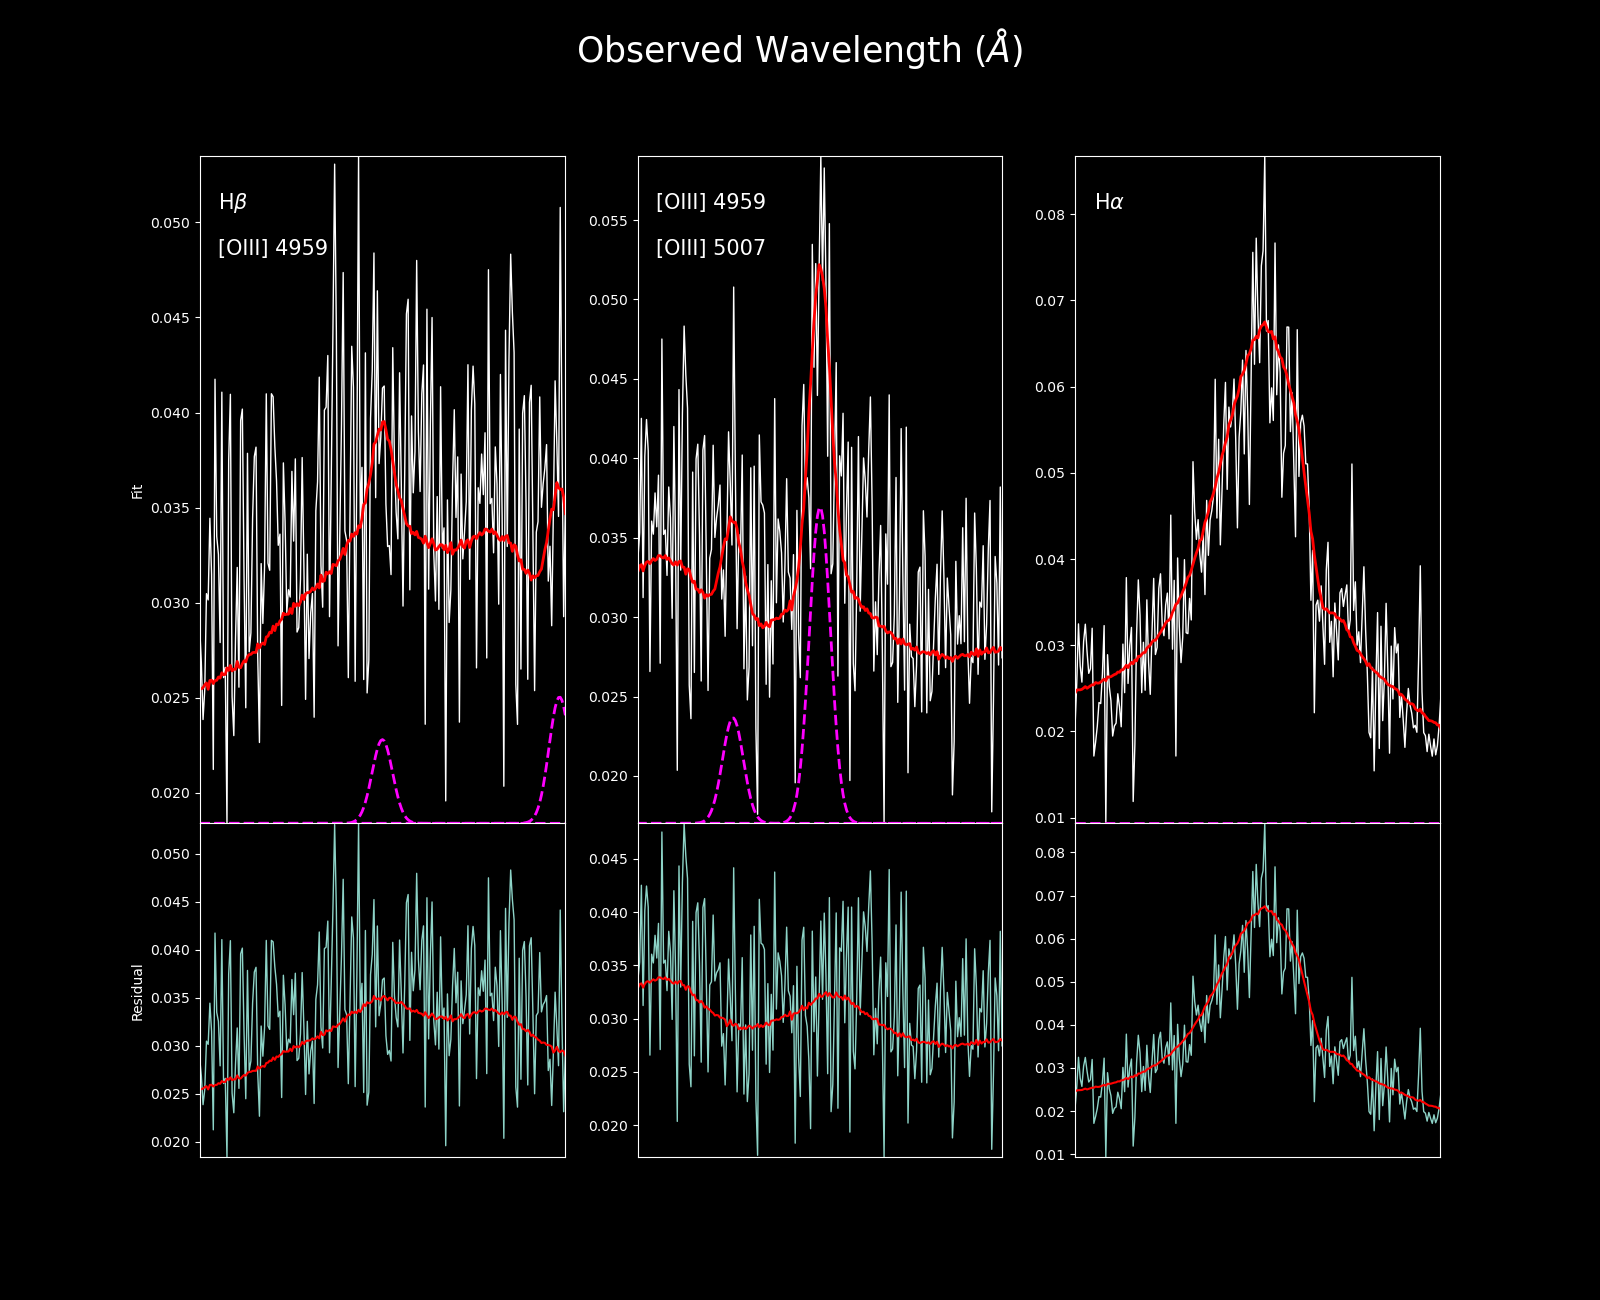

<IPython.core.display.Javascript object>


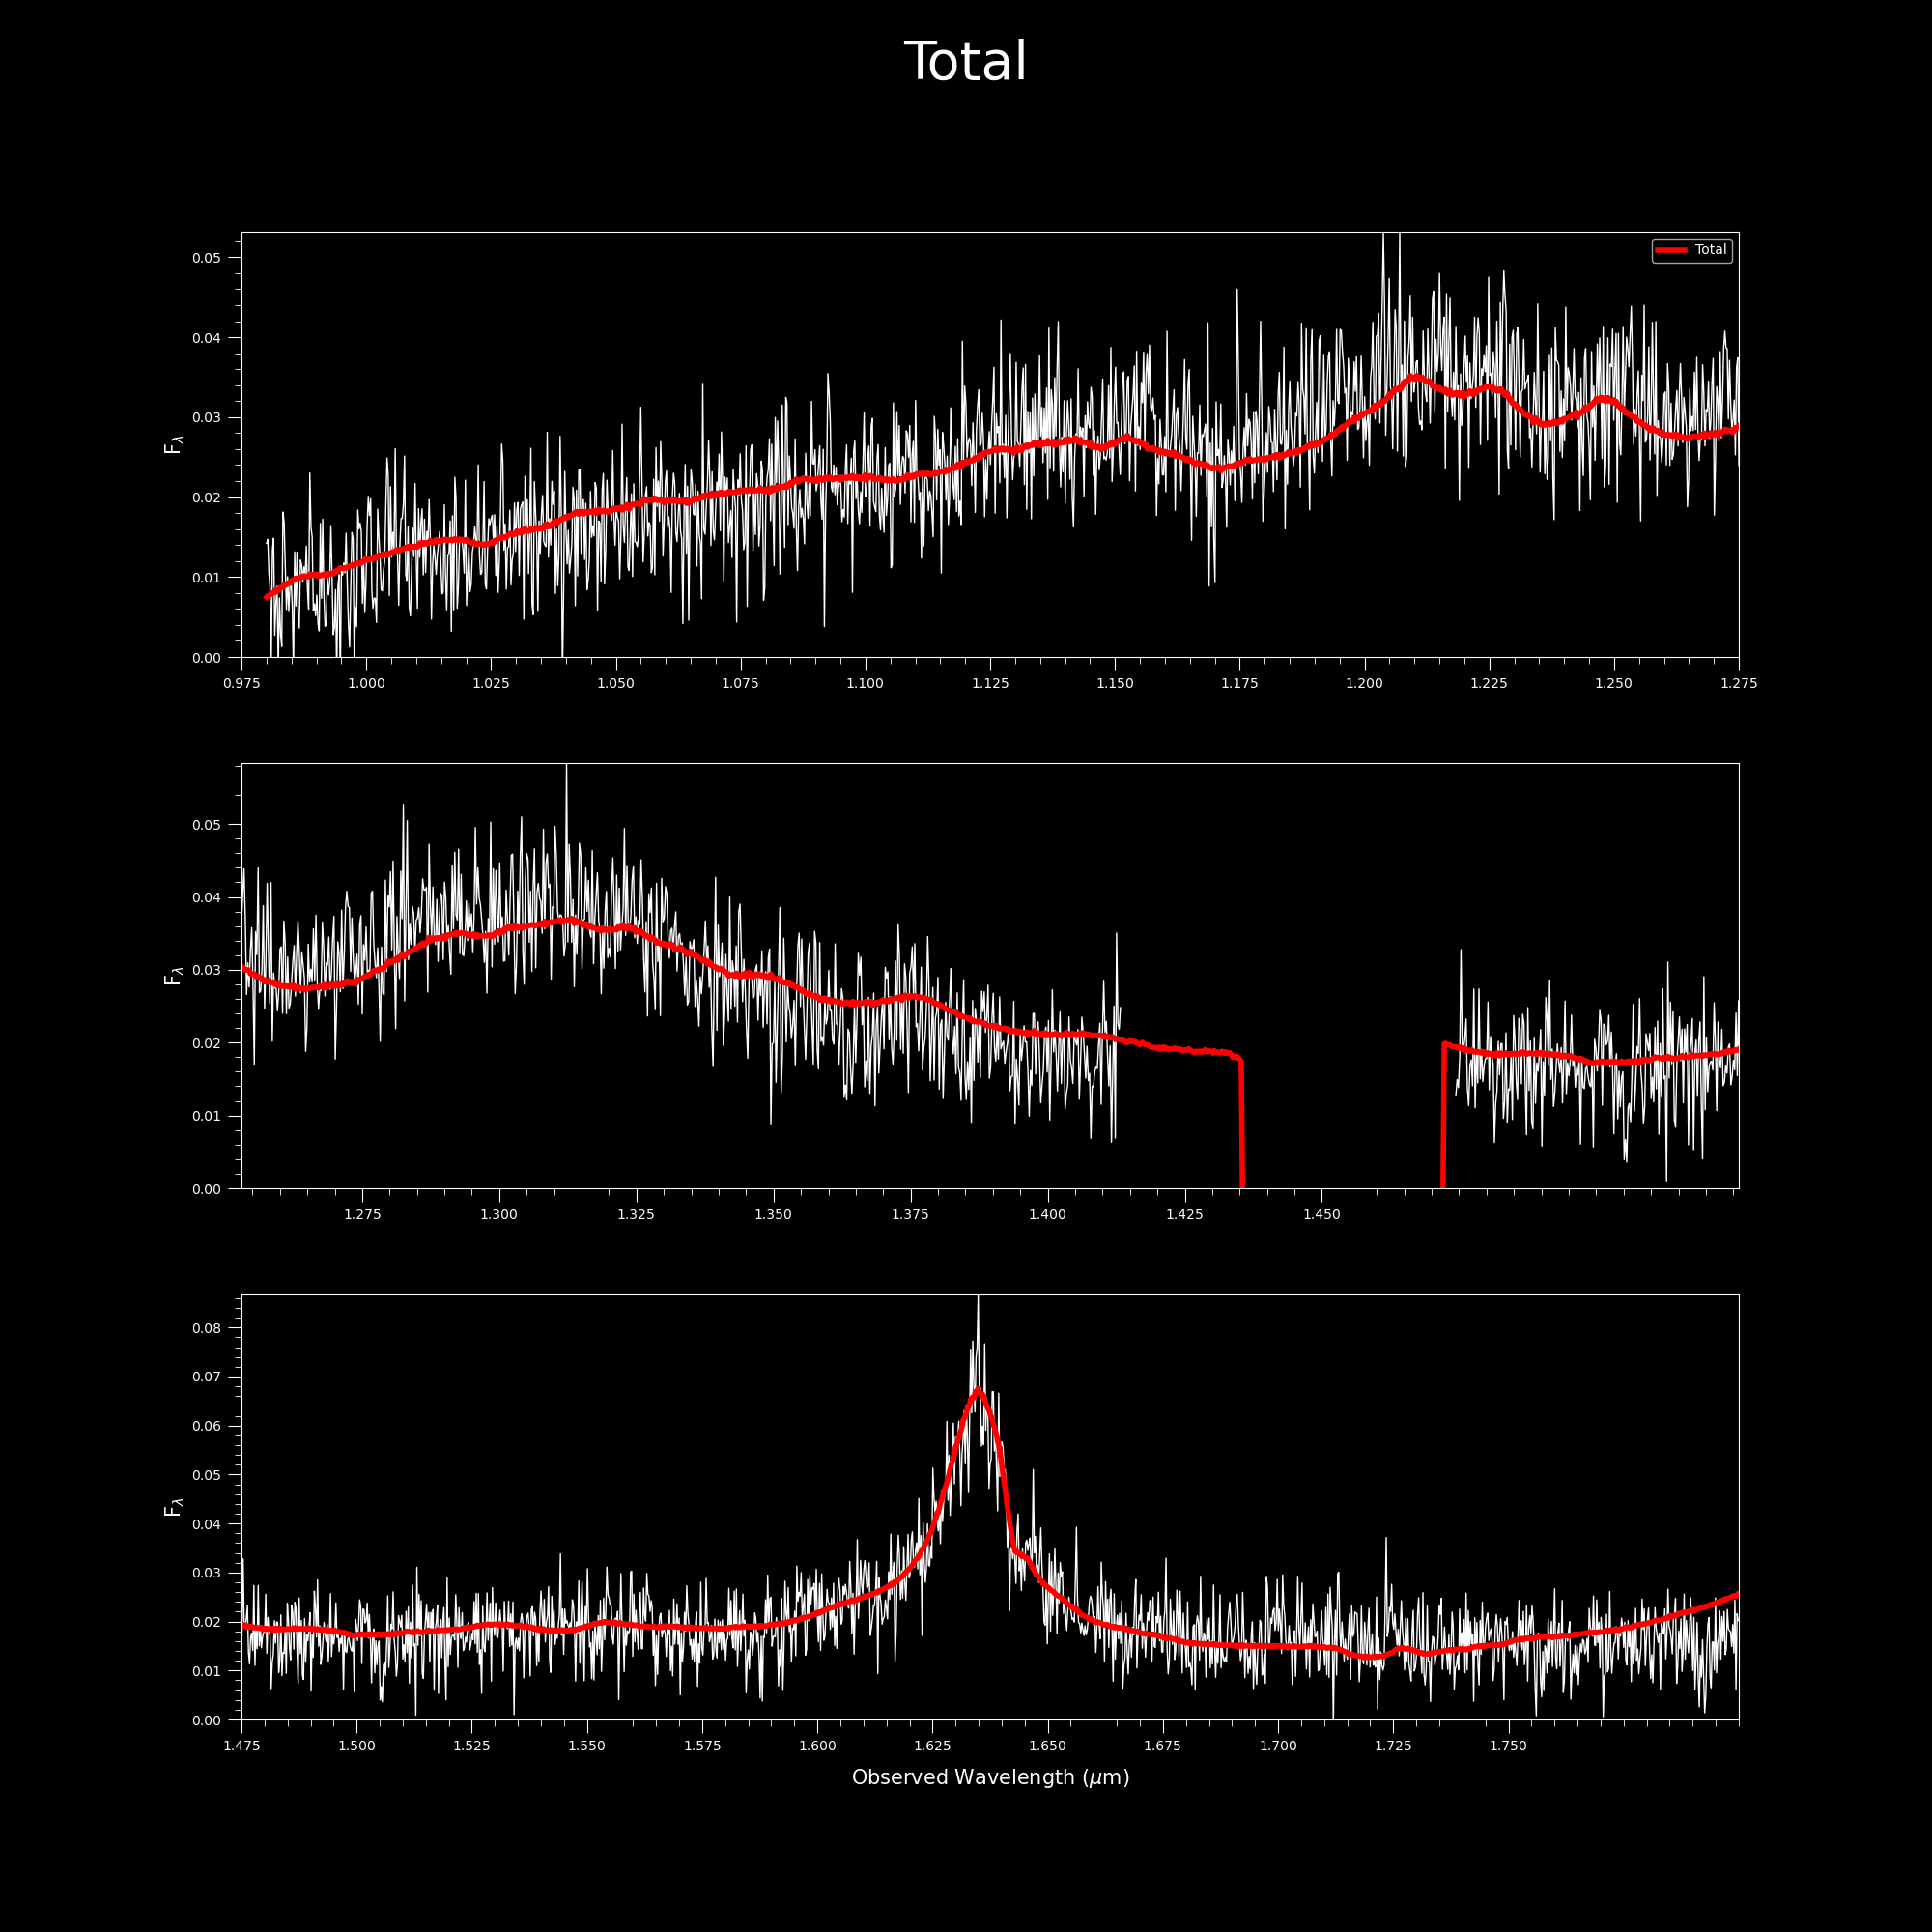

In [20]:
%matplotlib notebook
q3da(initproc,cols=cols,rows=rows)

Plots in an external, interactive window:

In [ ]:
%matplotlib
q3da(initproc,cols=cols,rows=rows)